# Predictive Modeling for Used Car Price Prediction

This notebook implements a comprehensive machine learning pipeline for predicting used car prices. The workflow includes:

- **Environment Setup**: Installing required packages and importing libraries
- **Data Loading**: Reading car data from a GitHub repository
- **Data Exploration**: Understanding data structure, missing values, and feature distributions
- **Data Cleaning & Feature Engineering**:
  - Extracting make and model from car names
  - Normalizing mileage, engine, max_power, and torque values
  - Creating derived features (age, km_per_year, frequency encodings)
  - Log-transforming the target variable to handle skewness
- **Model Training**:
  - Baseline models (Ridge, RandomForest, XGBoost, CatBoost, LightGBM)
  - Stacking ensemble
  - Cross-validation evaluation
  - LightGBM with target encoding for high-cardinality features
  - Quantile regression for prediction intervals
- **Model Interpretability**: SHAP analysis for feature importance
- **Model Deployment**: Saving artifacts and creating inference function

**Note**: The dataset is loaded from a GitHub URL. Python 3.10+ is recommended. Required packages are installed in the first code cell.


In [1]:
# Install required packages (skip if already installed in your environment)
!pip install -q shap lightgbm category_encoders catboost

# Standard library imports
import os
import gc
import math
import json
import joblib
import requests
import io
import warnings
warnings.filterwarnings('ignore')

# Data manipulation and analysis
import numpy as np
import pandas as pd
from datetime import datetime

# Machine learning and preprocessing
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
import inspect

# Advanced ML libraries
import lightgbm as lgb
import shap
import category_encoders as ce
import matplotlib.pyplot as plt

print('Setup complete')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00
Setup complete


## Data Source

The dataset is loaded from a GitHub repository containing car sales data in CSV format.


In [2]:
# Load dataset from GitHub repository
# The raw GitHub URL provides direct access to the CSV file content
url = "https://raw.githubusercontent.com/vimal-kanagaraj/dataset/main/CarData.csv"

df = pd.read_csv(url)

# Display first few rows to inspect the data structure
df.head()


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [3]:
# Display data types and basic information about the dataset
df.info()

# Print dataset dimensions
rows, columns = df.shape
print("Number of rows:", rows)
print("Number of columns:", columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB
Number of rows: 8128
Number of columns: 13


## Dataset Overview

This dataset contains information about **8,128 used cars** sold in the past. Each row represents a car listing with the following attributes:

**Car Identification & Basic Info:**
- `name`: Full car name (combines brand and model)
- `year`: Manufacturing year
- `selling_price`: Target variable - the price at which the car was sold

**Car Usage History:**
- `km_driven`: Total kilometers driven
- `owner`: Ownership history (First Owner, Second Owner, etc.)
- `seller_type`: Type of seller (Individual, Dealer, Trustmark Dealer)

**Car Specifications:**
- `fuel`: Fuel type (Diesel, Petrol, LPG, CNG)
- `transmission`: Transmission type (Manual, Automatic)
- `mileage`: Fuel efficiency (with units: kmpl or km/kg)
- `engine`: Engine displacement (in CC)
- `max_power`: Maximum power output (in bhp)
- `torque`: Torque specification (in Nm or kgm, with RPM range)
- `seats`: Number of seats

**Key Insight**: The selling price for Indian used cars is primarily influenced by:
- Car model and brand
- Age of the car (years since manufacturing)
- Driving history (total kilometers driven)


## Step 1: Data Understanding and Exploration


In [4]:
# Check for missing values across all columns
df.isnull().sum()


,0
name,0
year,0
selling_price,0
km_driven,0
fuel,0
seller_type,0
transmission,0
owner,0
mileage,221
engine,221


In [5]:
# Rename km_driven to kms_driven for consistency
df = df.rename(columns={'km_driven': 'kms_driven'})

# Categorize columns by data type for analysis
num_columns = ['year', 'selling_price', 'kms_driven', 'seats']
cat_columns = ['name', 'fuel', 'seller_type', 'transmission', 'owner']
mix_columns = ['mileage', 'engine', 'max_power', 'torque']  # Mixed format: numeric value + unit

# Analyze categorical columns: display unique values and their counts
for col in cat_columns:
    print(f"Column: {col}")
    print(f"Unique values: {df[col].unique()}")
    print(f"Count of unique values: {df[col].nunique()}")
    print("------")


Column: name
Unique values: ['Maruti Swift Dzire VDI' 'Skoda Rapid 1.5 TDI Ambition'
 'Honda City 2017-2020 EXi' ... 'Tata Nexon 1.5 Revotorq XT'
 'Ford Freestyle Titanium Plus Diesel BSIV'
 'Toyota Innova 2.5 GX (Diesel) 8 Seater BS IV']
Count of unique values: 2058
------
Column: fuel
Unique values: ['Diesel' 'Petrol' 'LPG' 'CNG']
Count of unique values: 4
------
Column: seller_type
Unique values: ['Individual' 'Dealer' 'Trustmark Dealer']
Count of unique values: 3
------
Column: transmission
Unique values: ['Manual' 'Automatic']
Count of unique values: 2
------
Column: owner
Unique values: ['First Owner' 'Second Owner' 'Third Owner' 'Fourth & Above Owner'
 'Test Drive Car']
Count of unique values: 5
------


In [6]:
# Analyze numerical columns: display statistical summary
df.describe()


,year,selling_price,kms_driven,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,5.416719
std,4.044249,8.062534e+05,5.655055e+04,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


In [7]:
# Analyze mixed-format columns (contain numeric values with units)
# These columns need parsing to extract numeric values
for col in mix_columns:
    print(f"Column: {col}")
    print(f"Unique values: {df[col].unique()}")
    print(f"Count of unique values: {df[col].nunique()}")
    print("------")


Column: mileage
Unique values: ['23.4 kmpl' '21.14 kmpl' '17.7 kmpl' '23.0 kmpl' '16.1 kmpl' '20.14 kmpl'
 '17.3 km/kg' '23.59 kmpl' '20.0 kmpl' '19.01 kmpl' '17.3 kmpl'
 '19.3 kmpl' nan '18.9 kmpl' '18.15 kmpl' '24.52 kmpl' '19.7 kmpl'
 '22.54 kmpl' '21.0 kmpl' '25.5 kmpl' '26.59 kmpl' '21.5 kmpl' '20.3 kmpl'
 '21.4 kmpl' '24.7 kmpl' '18.2 kmpl' '16.8 kmpl' '24.3 kmpl' '14.0 kmpl'
 '18.6 kmpl' '33.44 km/kg' '23.95 kmpl' '17.0 kmpl' '20.63 kmpl'
 '13.93 kmpl' '16.0 kmpl' '17.8 kmpl' '18.5 kmpl' '12.55 kmpl'
 '12.99 kmpl' '14.8 kmpl' '13.5 kmpl' '26.0 kmpl' '20.65 kmpl' '27.3 kmpl'
 '11.36 kmpl' '17.68 kmpl' '14.28 kmpl' '18.53 kmpl' '14.84 kmpl'
 '21.12 kmpl' '20.36 kmpl' '21.27 kmpl' '18.16 kmpl' '22.0 kmpl'
 '25.1 kmpl' '20.51 kmpl' '21.66 kmpl' '25.2 kmpl' '22.9 kmpl'
 '16.02 kmpl' '20.54 kmpl' '22.77 kmpl' '15.71 kmpl' '23.1 kmpl'
 '19.02 kmpl' '19.81 kmpl' '26.2 km/kg' '16.47 kmpl' '15.04 kmpl'
 '19.1 kmpl' '21.79 kmpl' '18.8 kmpl' '21.21 kmpl' '15.37 kmpl'
 '11.79 kmpl' '19.0 kmp

## Step 1: Key Findings

Based on the initial data exploration:

1. **Missing Values**: The dataset contains NULL values in car performance attributes:
   - `mileage`: 221 missing values
   - `engine`: 221 missing values
   - `max_power`: 215 missing values
   - `torque`: 222 missing values
   - `seats`: 221 missing values

2. **Car Name Structure**: The `name` column contains both brand and model information combined (e.g., "Maruti Swift Dzire VDI"). Splitting is required to extract separate make and model features.

3. **Year Column**: Can be used directly to calculate car age.

4. **Mixed-Format Columns**: The performance attributes (`mileage`, `engine`, `max_power`, `torque`) contain numeric values with units. Processing is needed to:
   - Extract numeric values
   - Handle missing values
   - Normalize units (e.g., convert km/kg to kmpl for mileage, kgm to Nm for torque)


## Step 2: Data Cleaning and Feature Extraction

### 2.1: Extract Brand (Make) and Model from Car Name


In [8]:
# Extract make (brand) as the first word from the car name
df['make'] = df['name'].str.split().str[0]

# Extract model as the second word from the car name, fill with 'Unknown' if missing
df['model'] = df['name'].str.split().str[1].fillna('Unknown')

# Display sample results
df[['name', 'make', 'model']].head()


,name,make,model
0,Maruti Swift Dzire VDI,Maruti,Swift
1,Skoda Rapid 1.5 TDI Ambition,Skoda,Rapid
2,Honda City 2017-2020 EXi,Honda,City
3,Hyundai i20 Sportz Diesel,Hyundai,i20
4,Maruti Swift VXI BSIII,Maruti,Swift


### 2.2: Clean and Normalize Mileage Column

Mileage values are stored with units (kmpl for Petrol/Diesel, km/kg for LPG/CNG). We need to:
- Split the numeric value from the unit
- Convert km/kg to kmpl using fuel density ratios


In [9]:
# Split mileage into numeric value and unit
# Temporarily fill NaNs with 'NaN NaN' to avoid errors during split
df[['mileage_value', 'mileage_unit']] = df['mileage'].fillna('NaN NaN').str.split(' ', expand=True)

# Replace placeholder 'NaN' strings with actual NaN values
df.replace('NaN', np.nan, inplace=True)

# Convert mileage_value to float, fill missing values with 0
df['mileage_value'] = pd.to_numeric(df['mileage_value'], errors='coerce').fillna(0)
print(f"Unique units for mileage: {df['mileage_unit'].unique()}")

# Normalize mileage to kmpl by converting km/kg to kmpl
# Fuel density ratios (kg/L) used for conversion
fuel_density = {
    'Petrol': 0.74,
    'Diesel': 0.832,
    'LPG': 0.51,
    'CNG': 0.615
}

# Function to normalize mileage: convert km/kg to kmpl based on fuel type
def normalize_mileage(row):
    if pd.isna(row['mileage_value']):
        return np.nan
    if row['mileage_unit'] == 'kmpl':
        return row['mileage_value']  # Already in kmpl
    elif row['mileage_unit'] == 'km/kg':
        # Convert km/kg to kmpl using fuel density
        density = fuel_density.get(row['fuel'], 0.74)  # Default to petrol if unknown
        return row['mileage_value'] / density
    else:
        return np.nan

# Apply normalization
df['mileage_kmpl'] = df.apply(normalize_mileage, axis=1)

# Display statistics
df['mileage_kmpl'].describe()
df['mileage_value'].describe()

# Verify conversion for CNG vehicles (which use km/kg)
df[(df['fuel'] == 'CNG') & (df['mileage_unit'] == 'km/kg')][['mileage', 'mileage_value', 'mileage_kmpl']].head()


Unique units for mileage: ['kmpl' 'km/kg' nan]


,mileage,mileage_value,mileage_kmpl
35,33.44 km/kg,33.44,54.373984
203,26.6 km/kg,26.60,43.252033
402,20.88 km/kg,20.88,33.951220
866,30.46 km/kg,30.46,49.528455
1225,21.94 km/kg,21.94,35.674797


In [10]:
# Split max_power into numeric value and unit
# Temporarily fill NaNs to avoid errors during split
df[['max_power_value', 'max_power_unit']] = df['max_power'].fillna('NaN NaN').str.split(' ', expand=True)

# Convert to numeric, fill missing with 0
df['max_power_value'] = pd.to_numeric(df['max_power_value'], errors='coerce').fillna(0)

print(f"Unique units for max_power: {df['max_power_unit'].unique()}")
df['max_power_value'].describe()

# Check rows where max_power extraction failed (value = 0)
df[(df['max_power_value'] == 0)][['max_power', 'max_power_value', 'max_power_unit']].head()


Unique units for max_power: ['bhp' 'NaN' None]


,max_power,max_power_value,max_power_unit
13,NaN,0.0,NaN
31,NaN,0.0,NaN
78,NaN,0.0,NaN
87,NaN,0.0,NaN
119,NaN,0.0,NaN


### 2.4: Clean and Extract Engine Displacement Values

Extract numeric engine displacement values (units are typically 'CC').


In [11]:
# Split engine into numeric value and unit
# Temporarily fill NaNs to avoid errors during split
df[['engine_value', 'engine_unit']] = df['engine'].fillna('NaN NaN').str.split(' ', expand=True)

# Convert to numeric, fill missing with 0
df['engine_value'] = pd.to_numeric(df['engine_value'], errors='coerce').fillna(0)

print(f"Unique units for engine: {df['engine_unit'].unique()}")
df['engine_value'].describe()

# Check rows where max_power extraction failed (to see if engine also failed)
df[(df['max_power_unit'] == 'NaN')][['engine', 'engine_value', 'engine_unit']].head()


Unique units for engine: ['CC' 'NaN']


,engine,engine_value,engine_unit
13,NaN,0.0,NaN
31,NaN,0.0,NaN
78,NaN,0.0,NaN
87,NaN,0.0,NaN
119,NaN,0.0,NaN


### 2.5: Clean and Normalize Torque Column

The torque column has complex formatting with various patterns:
- `'620Nm@ 2000-2500rpm'`
- `'19@ 1,800(kgm@ rpm)'`
- `'51Nm@ 4000+/-500rpm'`
- `'24 KGM at 1900-2750 RPM'`
- `'190Nm@ 1750-2250rpm'`
- `'250Nm@ 1500~4500rpm'`
- `'96 Nm at 3000 rpm'`

We need to:
- Extract torque value and normalize units (convert kgm to Nm)
- Extract RPM information (handle ranges, +/- notation, single values)


In [12]:
# Clean torque string: remove special characters and normalize format
df['torque_clean'] = (
    df['torque']
    .str.replace(',', '', regex=False)      # Remove commas
    .str.replace('(', '', regex=False)      # Remove opening parentheses
    .str.replace(')', '', regex=False)      # Remove closing parentheses
    .str.replace('~', '-', regex=False)     # Replace ~ with - for range notation
    .str.replace('at', '@', case=False, regex=False)  # Normalize 'at' to '@'
    .str.replace('rpm', '', case=False, regex=False)  # Remove 'rpm' text
    .str.strip()                            # Remove leading/trailing whitespace
)

# Extract torque numeric value (first number in the string)
df['torque_value'] = df['torque_clean'].fillna('Nan').str.extract(r'^(\d+\.?\d*)')[0].astype(float)
df['torque_value'] = pd.to_numeric(df['torque_value'], errors='coerce').fillna(0)

# Extract torque unit (Nm, nm, KGM, KGm, kgm) and normalize to lowercase
df['torque_unit'] = df['torque_clean'].str.extract(r'(Nm|nm|KGM|KGm|kgm)')
df['torque_unit'] = df['torque_unit'].str.lower()
print(f"Unique units for Torque: {df['torque_unit'].unique()}")

df[['torque', 'torque_value', 'torque_unit']].head()

# Normalize torque to Nm: convert kgm to Nm (1 kgm = 9.80665 Nm)
def normalize_torque(row):
    if pd.isna(row['torque_value']):
        return np.nan
    if row['torque_unit'] == 'nm':
        return row['torque_value']  # Already in Nm
    elif row['torque_unit'] == 'kgm':
        return row['torque_value'] * 9.80665  # Convert kgm to Nm
    else:
        return np.nan

df['torque_nm'] = df.apply(normalize_torque, axis=1).fillna(0)
df['torque_nm'].describe()

# Extract average RPM from torque string
# Handle three patterns: +/- notation, range (a-b), or single value after @
df['rpm_avg'] = df['torque_clean'].fillna('NaN').str.extract(r'(\d+)\s*\+/-\s*\d+')
range_extract = df['torque_clean'].str.extract(r'(\d+)\s*-\s*(\d+)')

# For ranges, calculate average of the two numbers
df['rpm_avg'] = range_extract[[0, 1]].astype(float).mean(axis=1)
# For single values after @, extract that number
df['rpm_avg'] = df['rpm_avg'].fillna(df['torque_clean'].str.extract(r'@\s*(\d+)')[0])
df['rpm_avg'] = pd.to_numeric(df['rpm_avg'], errors='coerce').fillna(0)
df['rpm_avg'].describe()


Unique units for Torque: ['nm' 'kgm' nan]


,rpm_avg
count,8128.000000
mean,2796.908649
std,1101.949213
min,0.000000
25%,2000.000000
50%,2400.000000
75%,4000.000000
max,21800.000000


In [13]:
# Verify torque cleaning results
df[['torque', 'torque_value', 'torque_unit', 'torque_nm']].head()
df[['torque', 'rpm_avg']].head()


,torque,rpm_avg
0,190Nm@ 2000rpm,2000.0
1,250Nm@ 1500-2500rpm,2000.0
2,"12.7@ 2,700(kgm@ rpm)",2700.0
3,22.4 kgm at 1750-2750rpm,2250.0
4,"11.5@ 4,500(kgm@ rpm)",4500.0


## Step 3: Feature Engineering

Create additional features that help predict selling price:

1. **Car Age**: Calculate years since manufacturing
2. **Kilometers per Year**: Average annual driving distance
3. **Abnormal Usage Flag**: Identify unusual usage patterns (<50 km/year or >50,000 km/year)
4. **Log Transformation**: Apply log1p transformation to selling_price to handle right-skewed distribution


In [14]:
# Calculate car age (years since manufacturing)
current_year = datetime.now().year
df['age'] = current_year - df['year']

# Calculate average kilometers driven per year
df['km_per_year'] = df['kms_driven'] / df['age']

# Flag abnormal usage patterns (very low or very high annual mileage)
df['km_per_year_flag'] = ((df['km_per_year'] > 50000) | (df['km_per_year'] < 50)).astype(int)

# Apply log transformation to selling_price to handle right-skewed distribution
# Using log1p (log(1+x)) to handle zero values gracefully
df['log_selling_price'] = np.log1p(df['selling_price'])

# Convert seats to integer, fill missing with 0
df['seat'] = df['seats'].fillna(0).astype(int)

# Round float columns to 3 decimal places for cleaner display
float_cols = df.select_dtypes(include='float')
df[float_cols.columns] = float_cols.round(3)

# Display updated dataframe
df.head()


,name,year,selling_price,kms_driven,fuel,seller_type,transmission,owner,mileage,engine,...,torque_clean,torque_value,torque_unit,torque_nm,rpm_avg,age,km_per_year,km_per_year_flag,log_selling_price,seat
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,...,190Nm@ 2000,190.0,nm,190.000,2000.0,11,13227.273,0,13.017,5
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,...,250Nm@ 1500-2500,250.0,nm,250.000,2000.0,11,10909.091,0,12.821,5
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,...,12.7@ 2700kgm@,12.7,kgm,124.544,2700.0,19,7368.421,0,11.970,5
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,...,22.4 kgm @ 1750-2750,22.4,kgm,219.669,2250.0,15,8466.667,0,12.324,5
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,...,11.5@ 4500kgm@,11.5,kgm,112.776,4500.0,18,6666.667,0,11.775,5


## Exploratory Data Analysis (EDA)

This section explores the cleaned and engineered data to understand feature distributions, identify correlations, and gain insights into factors affecting car prices.


In [15]:
# Import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Display dataframe structure after feature engineering
print("Dataframe Information:")
df.info()

# Display statistical summary of key numerical features
# Using original selling_price (not log-transformed) to understand real-world scale
print("\n\nNumerical Feature Statistics:")
display(df[['selling_price', 'age', 'kms_driven', 'km_per_year']].describe())


Dataframe Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8128 non-null   object 
 1   year               8128 non-null   int64  
 2   selling_price      8128 non-null   int64  
 3   kms_driven         8128 non-null   int64  
 4   fuel               8128 non-null   object 
 5   seller_type        8128 non-null   object 
 6   transmission       8128 non-null   object 
 7   owner              8128 non-null   object 
 8   mileage            7907 non-null   object 
 9   engine             7907 non-null   object 
 10  max_power          7913 non-null   object 
 11  torque             7906 non-null   object 
 12  seats              7907 non-null   float64
 13  make               8128 non-null   object 
 14  model              8128 non-null   object 
 15  mileage_value      8128 non-null   float64
 16  m

,selling_price,age,kms_driven,km_per_year
count,8.128000e+03,8128.000000,8.128000e+03,8128.000000
mean,6.382718e+05,11.195989,6.981951e+04,6111.240414
std,8.062534e+05,4.044249,5.655055e+04,4149.162975
min,2.999900e+04,5.000000,1.000000e+00,0.071000
25%,2.549990e+05,8.000000,3.500000e+04,3500.000000
50%,4.500000e+05,10.000000,6.000000e+04,5555.556000
75%,6.750000e+05,14.000000,9.800000e+04,7857.143000
max,1.000000e+07,42.000000,2.360457e+06,131136.500000


### 1. Target Variable Distribution Analysis

Compare the distribution of original selling_price vs. log-transformed selling_price to validate the transformation choice.


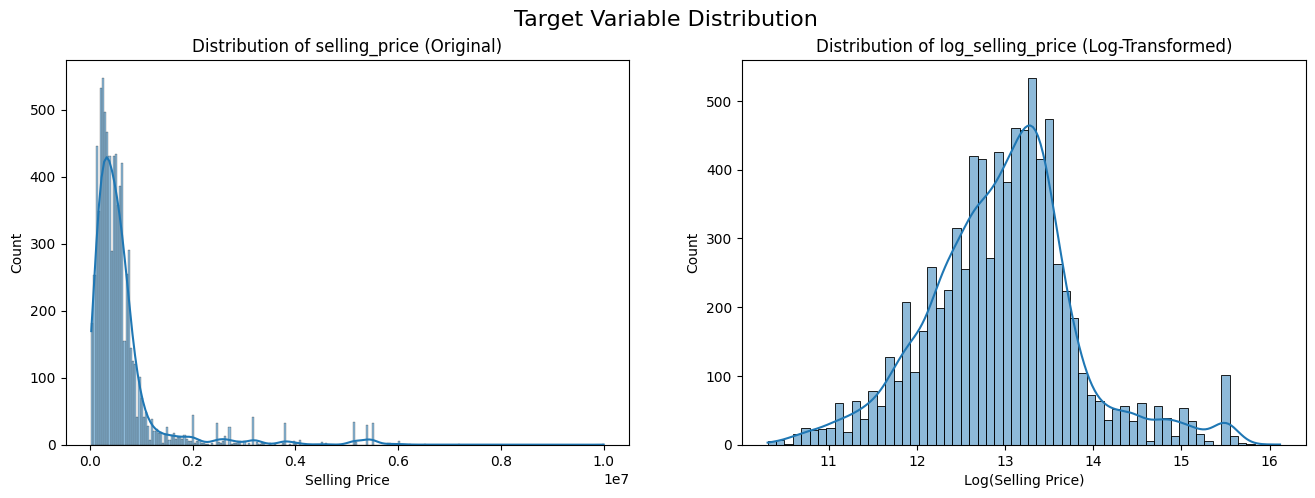

In [16]:
# Create side-by-side histograms comparing original and log-transformed prices
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot original selling_price distribution
sns.histplot(df['selling_price'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of selling_price (Original)')
axes[0].set_xlabel('Selling Price')

# Plot log-transformed selling_price distribution
sns.histplot(df['log_selling_price'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of log_selling_price (Log-Transformed)')
axes[1].set_xlabel('Log(Selling Price)')

plt.suptitle('Target Variable Distribution', fontsize=16)
plt.show()


**Key Observations:**
- The original `selling_price` distribution is heavily **right-skewed**, which is typical for price data
- The `log_selling_price` distribution is much more **normally distributed**
- This confirms that training models on log-transformed prices is the appropriate approach


### 2. Numerical Feature Correlation Analysis

Examine correlations between numerical features and the target variable (log_selling_price).


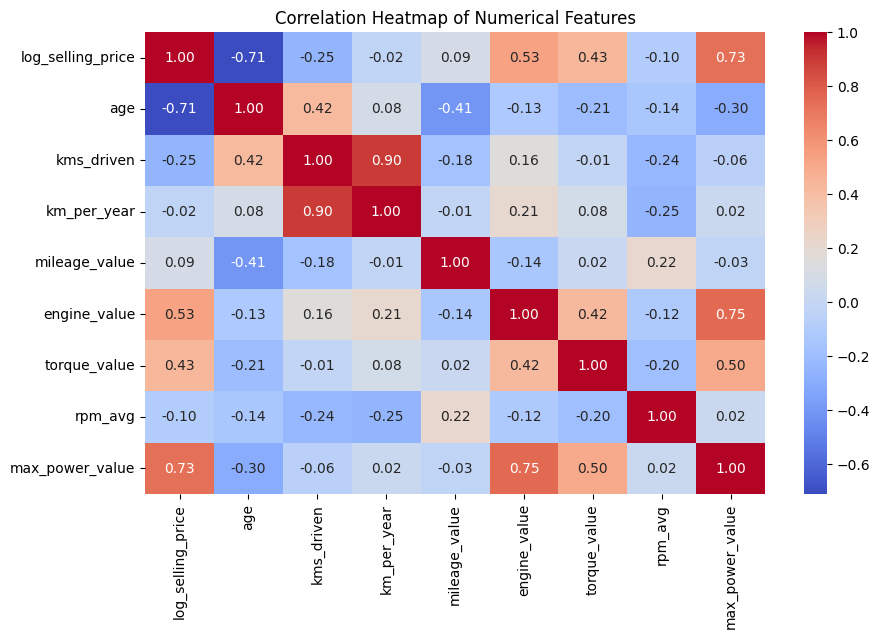

In [17]:
# Create correlation heatmap for numerical features
plt.figure(figsize=(10, 6))

# Select numerical features for correlation analysis
corr_features = ['log_selling_price', 'age', 'kms_driven', 'km_per_year', 'mileage_value',
                 'engine_value', 'torque_value', 'rpm_avg', 'max_power_value']
corr_matrix = df[corr_features].corr()

# Display correlation heatmap with annotations
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


**Key Correlations:**
- **`age`**: Strong negative correlation (-0.71) with `log_selling_price` - older cars are cheaper
- **`kms_driven`**: Moderate negative correlation (-0.25) - higher mileage reduces price
- **`km_per_year`**: Very weak correlation (-0.02) - may not be useful as a standalone feature
- **`max_power_value`**, **`engine_value`**: Positive correlations - more powerful cars are more expensive


### 3. Categorical Feature Impact Analysis

Visualize how categorical features (fuel type, transmission, owner) affect car prices.


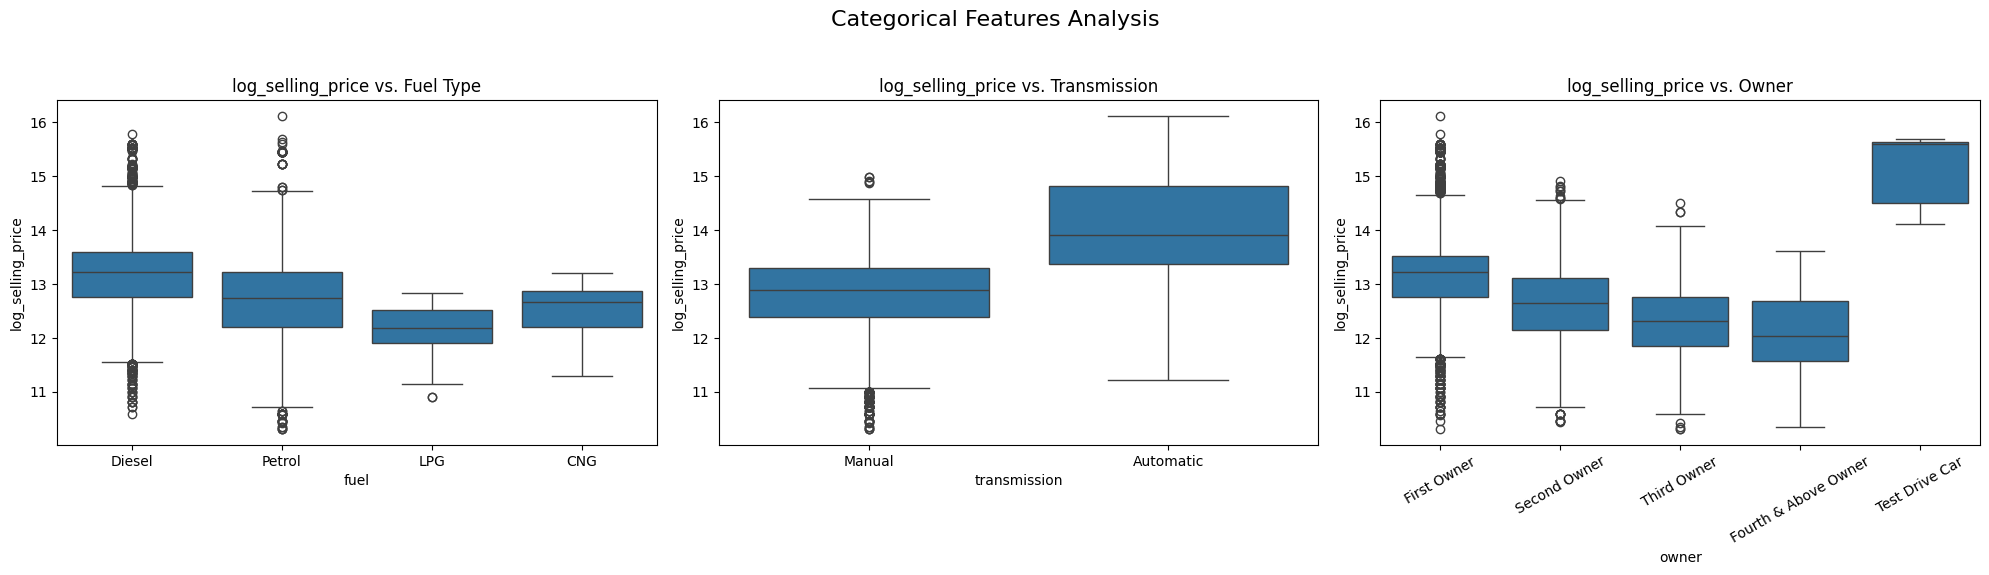

In [18]:
# Create boxplots comparing log_selling_price across categorical features
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Fuel Type vs. Price
sns.boxplot(data=df, x='fuel', y='log_selling_price', ax=axes[0])
axes[0].set_title('log_selling_price vs. Fuel Type')

# Transmission vs. Price
sns.boxplot(data=df, x='transmission', y='log_selling_price', ax=axes[1])
axes[1].set_title('log_selling_price vs. Transmission')

# Owner vs. Price
sns.boxplot(data=df, x='owner', y='log_selling_price', ax=axes[2])
axes[2].set_title('log_selling_price vs. Owner')
axes[2].tick_params(axis='x', rotation=30)  # Rotate labels for readability

plt.suptitle('Categorical Features Analysis', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**Key Insights:**
- **Fuel Type**: Diesel cars have significantly higher median prices than Petrol, LPG, or CNG
- **Transmission**: Automatic cars are clearly more expensive than Manual cars
- **Owner**: First Owner cars tend to be most expensive, with prices decreasing for Second, Third, and Fourth & Above owners (Test Drive Car is an outlier)


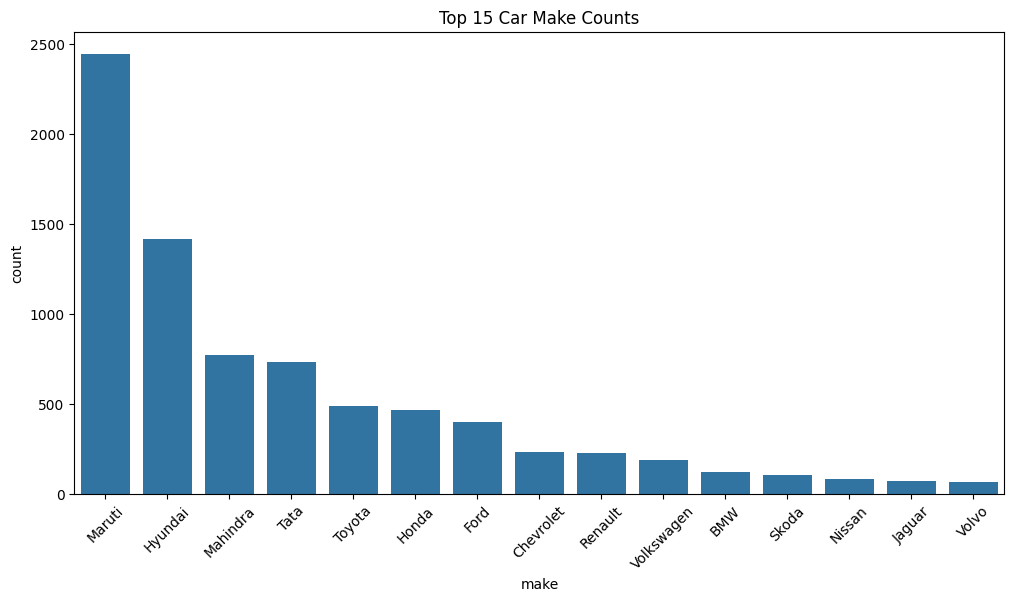

In [19]:
# Analyze high-cardinality feature: Car Make
plt.figure(figsize=(12, 6))

# Display top 15 most common car makes
top_makes = df['make'].value_counts().nlargest(15).index
sns.countplot(data=df, x='make', order=top_makes)
plt.title('Top 15 Car Make Counts')
plt.xticks(rotation=45)
plt.show()


**Observation**: The dataset is heavily dominated by `Maruti`, `Hyundai`, and `Mahindra` brands.


## Feature Encoding and Feature Lists

Create frequency encodings for high-cardinality features and define feature lists for modeling.


In [20]:
# Create frequency encoding for make and model (normalized frequency of occurrence)
for col in ['make', 'model']:
    freq_map = df[col].value_counts(normalize=True)
    df[f'{col}_freq'] = df[col].map(freq_map)

# Create residual encoding for model (deviation from overall mean price)
model_avg = df.groupby('model')['log_selling_price'].mean()
df['model_residual'] = df['model'].map(model_avg) - df['log_selling_price'].mean()

# Define feature lists for modeling
# Numeric features: includes engineered features and extracted performance metrics
numeric_features = ['age', 'kms_driven', 'km_per_year', 'make_freq', 'model_freq', 'model_residual',
                    'mileage_value', 'engine_value', 'torque_value', 'rpm_avg', 'max_power_value']

# Low-cardinality categorical features (suitable for one-hot encoding)
categorical_low_card = ['fuel', 'transmission', 'owner']

# High-cardinality categorical features (suitable for target encoding)
high_card = ['make', 'model']

print('Numeric features:', numeric_features)
print('Low-card categorical features:', categorical_low_card)
print('High-card features:', high_card)

df.shape


Numeric features: ['age', 'kms_driven', 'km_per_year', 'make_freq', 'model_freq', 'model_residual', 'mileage_value', 'engine_value', 'torque_value', 'rpm_avg', 'max_power_value']
Low-card categorical features: ['fuel', 'transmission', 'owner']
High-card features: ['make', 'model']


(8128, 35)

## Preprocessing Pipeline Configuration

Define preprocessing pipelines for numerical and categorical features.


In [21]:
# Numerical feature pipeline: impute missing values with median, then standardize
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Low-cardinality categorical pipeline: impute missing with 'missing', then one-hot encode
cat_low_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combined preprocessor for LightGBM (excludes high-cardinality features - handled separately)
preprocessor_lgb = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('lowcat', cat_low_transformer, categorical_low_card)
])
print('Preprocessor ready')


Preprocessor ready


## Train/Test Split

Perform stratified split based on price deciles to ensure balanced distribution of price ranges in train and test sets.


In [22]:
# Create price deciles for stratified splitting
df['price_decile'] = pd.qcut(df['selling_price'], 10, labels=False, duplicates='drop')

# Identify all features that exist in the dataframe
all_expected = numeric_features + categorical_low_card + high_card
existing_features = [c for c in all_expected if c in df.columns]

# Perform stratified train-test split (85% train, 15% test)
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df['price_decile'])

# Create feature matrices and target vectors
X_train = train_df[existing_features].copy()
y_train = train_df['log_selling_price']
X_test = test_df[existing_features].copy()
y_test = test_df['log_selling_price']

print('Train size:', X_train.shape[0], 'Test size:', X_test.shape[0])


Train size: 6908 Test size: 1220


In [23]:
# Define helper functions for model training and evaluation

def prediction_model(model, preprocessor, X_train, y_train, X_test, y_test):
    """
    Train a model with preprocessing pipeline and return predictions.

    Args:
        model: Scikit-learn compatible model
        preprocessor: Preprocessing pipeline (ColumnTransformer)
        X_train, y_train: Training data
        X_test, y_test: Test data

    Returns:
        Tuple of (train_predictions, test_predictions)
    """
    # Combine preprocessor and model into a single pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Train the pipeline
    pipeline.fit(X_train, y_train)

    # Generate predictions
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    # Print evaluation metrics
    print('RF Train:', eval_preds(y_train, pred_train))
    print('RF Test:', eval_preds(y_test, pred_test))

    return (pred_train, pred_test)

def eval_preds(y_true_log, y_pred_log):
    """
    Evaluate predictions on log-transformed target.
    Converts back to original scale for RMSE and MAE calculation.

    Args:
        y_true_log: True values in log space
        y_pred_log: Predicted values in log space

    Returns:
        Dictionary with RMSE, MAE, and R2_log metrics
    """
    # Convert from log space to original price scale
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)

    return {
        'RMSE': sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2_log': r2_score(y_true_log, y_pred_log)
    }

def plot_pred_residuals(y_test, pred_test):
    """
    Plot residuals (actual - predicted) vs. predicted values.
    Useful for identifying prediction bias and heteroscedasticity.
    """
    # Convert from log space to original price scale
    y_test_orig = np.expm1(y_test)
    pred_test_orig = np.expm1(pred_test)

    residuals = y_test_orig - pred_test_orig

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=pred_test_orig, y=residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Price (Baseline)')
    plt.ylabel('Residual (Actual - Predicted)')
    plt.title('Baseline Model Residual Plot')
    plt.ticklabel_format(style='plain', axis='x')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()


## Baseline Model: Ridge Regression

Establish a baseline performance using Ridge Regression. This linear model will help measure the improvement gained from more complex models.


The baseline pipeline:
1. Applies `numeric_transformer` (median imputation + standardization) to numerical features
2. Applies `cat_low_transformer` (constant imputation + one-hot encoding) to low-cardinality categorical features
3. Trains a `Ridge(alpha=1.0)` model on the transformed features


RF Train: {'RMSE': 194356.373596404, 'MAE': 102555.92738993757, 'R2_log': 0.9171550704603795}
RF Test: {'RMSE': 189185.0131202953, 'MAE': 102353.45894111754, 'R2_log': 0.9088675645735924}


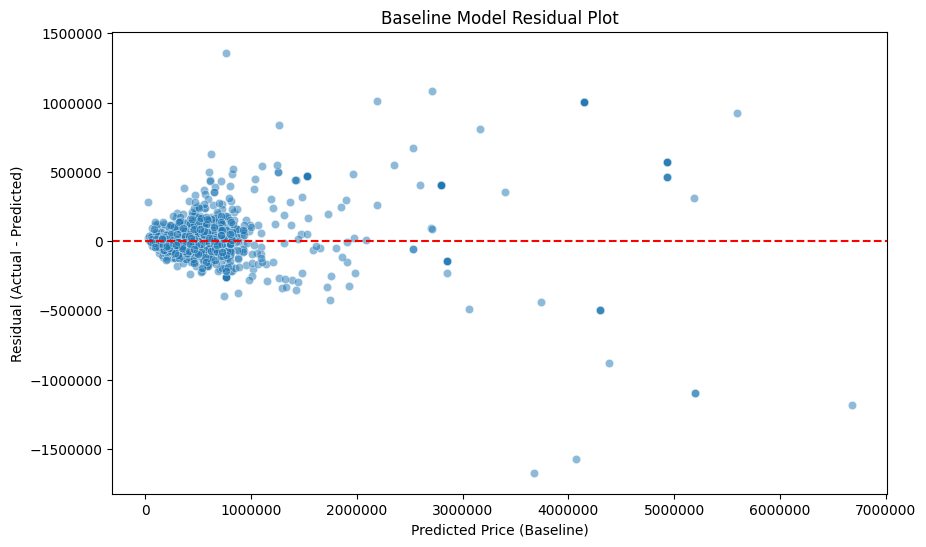

In [24]:
# Create preprocessor for baseline model
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('lowcat', cat_low_transformer, categorical_low_card)
])

# Define Ridge regression model with L2 regularization (alpha=1.0)
model_ridge = Ridge(alpha=1.0)

# Train and evaluate
(pred_train, pred_test) = prediction_model(model_ridge, preprocessor, X_train, y_train, X_test, y_test)

# Plot residuals
plot_pred_residuals(y_test, pred_test)


## Random Forest Regressor

Train a Random Forest model to capture non-linear relationships and feature interactions.


RF Train: {'RMSE': 69950.81216470244, 'MAE': 41281.27283284777, 'R2_log': 0.9798980343190158}
RF Test: {'RMSE': 103909.95619002334, 'MAE': 61780.43212567686, 'R2_log': 0.944065347242973}


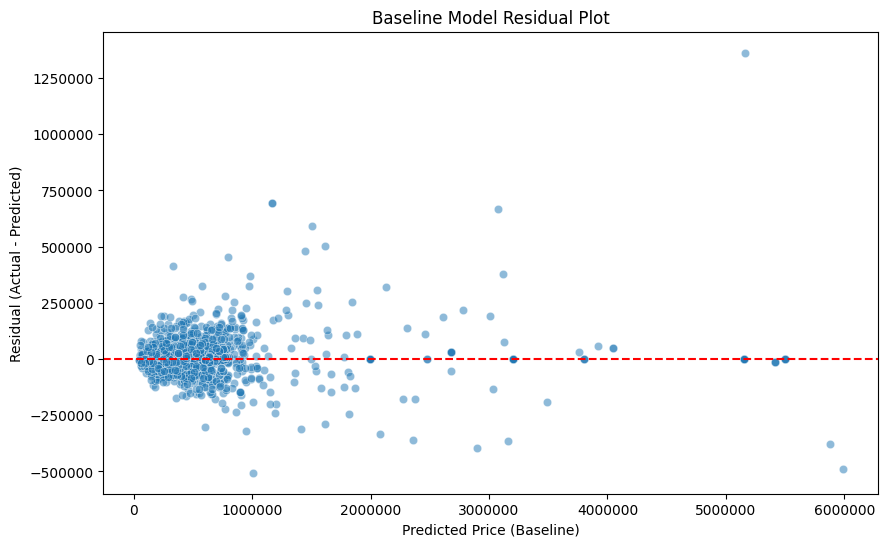

In [25]:
from sklearn.ensemble import RandomForestRegressor

# Create preprocessor
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('lowcat', cat_low_transformer, categorical_low_card)
])

# Define Random Forest model
model_rf = RandomForestRegressor(
    n_estimators=50,      # Number of decision trees
    max_depth=12,          # Maximum depth of each tree
    random_state=42,
    n_jobs=-1             # Use all CPU cores for parallel processing
)

# Train and evaluate
(pred_train, pred_test) = prediction_model(model_rf, preprocessor, X_train, y_train, X_test, y_test)

# Plot residuals
plot_pred_residuals(y_test, pred_test)


## XGBoost Regressor

Train an XGBoost gradient boosting model for improved performance.


RF Train: {'RMSE': 17885.997771424587, 'MAE': 6486.8837447371525, 'R2_log': 0.9981279886469219}
RF Test: {'RMSE': 94875.54154638255, 'MAE': 54252.99030478544, 'R2_log': 0.945684737682476}


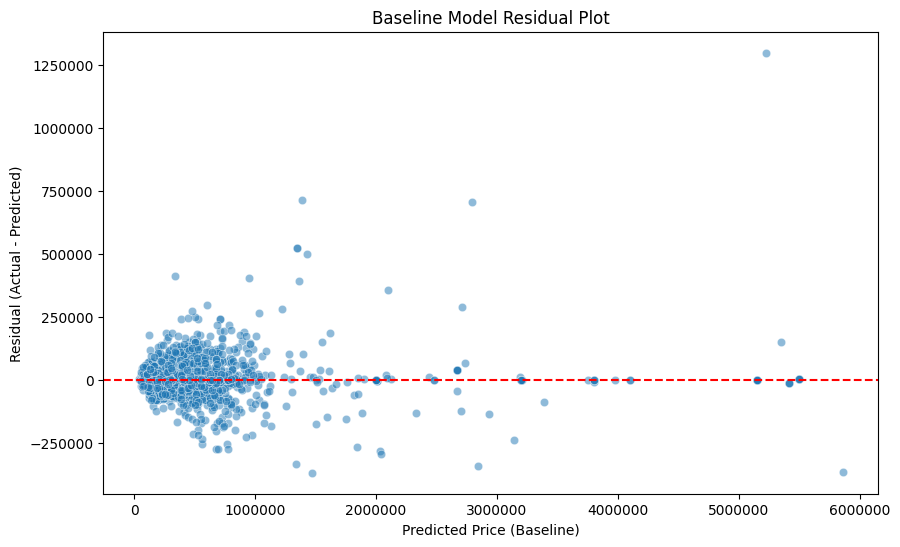

In [26]:
from xgboost import XGBRegressor

# Create preprocessor
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('lowcat', cat_low_transformer, categorical_low_card)
])

# Define XGBoost model with regularization and subsampling
model_xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=12,
    subsample=0.8,              # Row subsampling ratio
    colsample_bytree=0.8,      # Column subsampling ratio
    random_state=42
)

# Train and evaluate
(pred_train, pred_test) = prediction_model(model_xgb, preprocessor, X_train, y_train, X_test, y_test)

# Plot residuals
plot_pred_residuals(y_test, pred_test)


## CatBoost Regressor

Train a CatBoost model, which handles categorical features natively without explicit encoding.


RF Train: {'RMSE': 73555.6909044218, 'MAE': 45348.85122187696, 'R2_log': 0.9752343404670988}
RF Test: {'RMSE': 92684.13087714737, 'MAE': 57019.51603212456, 'R2_log': 0.9508556219257658}


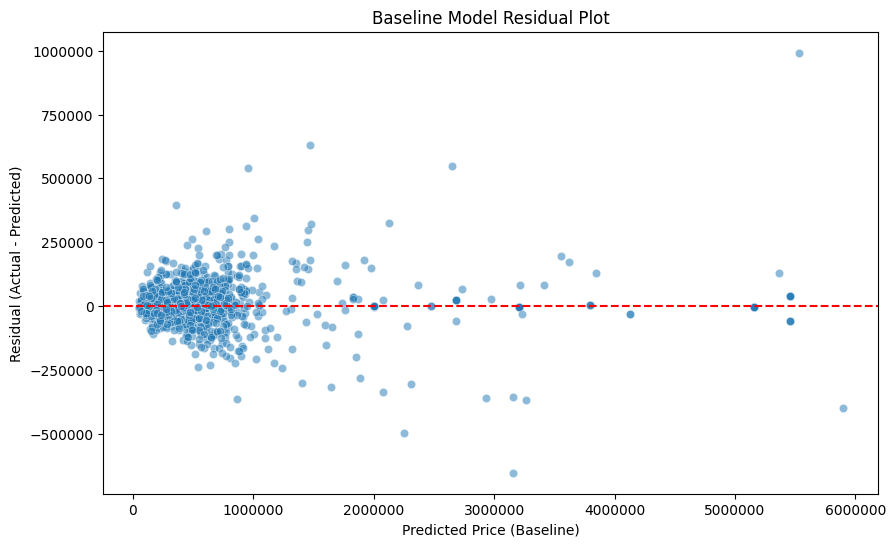

In [27]:
from catboost import CatBoostRegressor

# Create preprocessor
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('lowcat', cat_low_transformer, categorical_low_card)
])

# Define CatBoost model
model_cat = CatBoostRegressor(
    iterations=800,
    learning_rate=0.05,
    depth=8,
    verbose=0                   # Suppress training output
)

# Train and evaluate
(pred_train, pred_test) = prediction_model(model_cat, preprocessor, X_train, y_train, X_test, y_test)

# Plot residuals
plot_pred_residuals(y_test, pred_test)


## LightGBM Regressor

Train a LightGBM gradient boosting model, known for efficiency and performance.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1630
[LightGBM] [Info] Number of data points in the train set: 6908, number of used features: 21
[LightGBM] [Info] Start training from score 12.973491
RF Train: {'RMSE': 79686.78637251895, 'MAE': 43737.27615271111, 'R2_log': 0.9764066953488125}
RF Test: {'RMSE': 105233.81743163832, 'MAE': 59480.695238490356, 'R2_log': 0.9487130382458974}


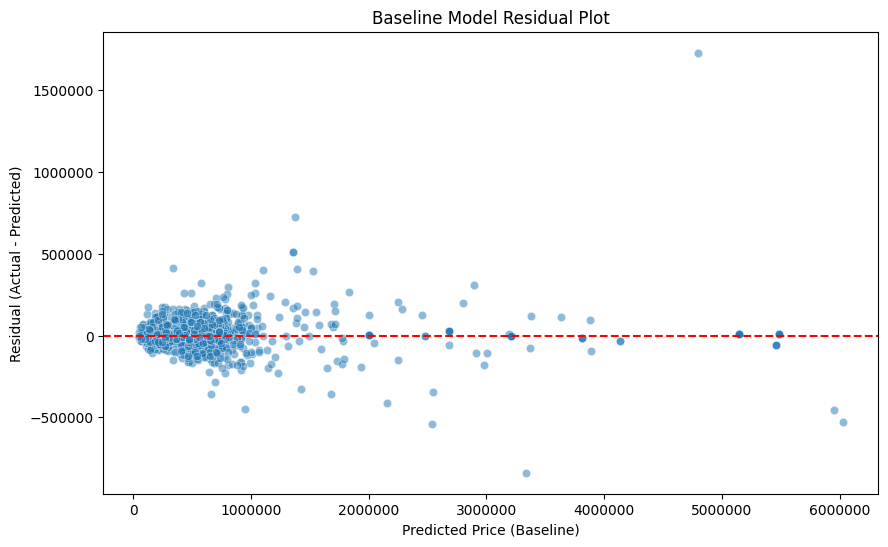

In [28]:
from lightgbm import LGBMRegressor

# Create preprocessor
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('lowcat', cat_low_transformer, categorical_low_card)
])

# Define LightGBM model
model_lgb = LGBMRegressor(
    n_estimators=800,
    learning_rate=0.03,
    num_leaves=31
)

# Train and evaluate
(pred_train, pred_test) = prediction_model(model_lgb, preprocessor, X_train, y_train, X_test, y_test)

# Plot residuals
plot_pred_residuals(y_test, pred_test)


## Stacking Ensemble

Combine multiple models using a stacking ensemble with Ridge as the meta-learner.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1630
[LightGBM] [Info] Number of data points in the train set: 6908, number of used features: 21
[LightGBM] [Info] Start training from score 12.973491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1599
[LightGBM] [Info] Number of data points in the train set: 5526, number of used features: 21
[LightGBM] [Info] Start training from score 12.973651
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

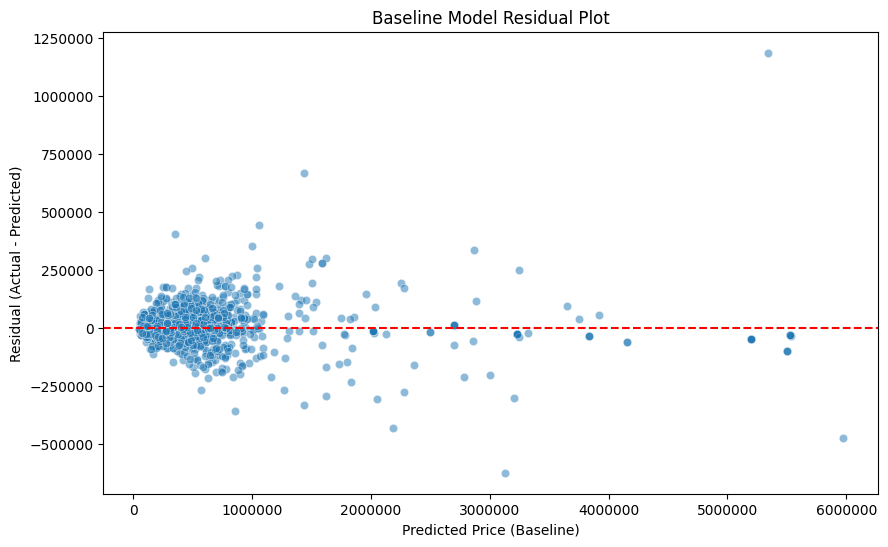

In [29]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Define base models for stacking
base_models = [
    ('cat', model_cat),
    ('lgb', model_lgb),
    ('xgb', model_xgb),
]

# Use Ridge as meta-learner (final estimator)
meta_model = model_ridge

# Create stacking regressor with 5-fold cross-validation
stack = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)

# Train and evaluate
(pred_train, pred_test) = prediction_model(stack, preprocessor, X_train, y_train, X_test, y_test)

# Plot residuals
plot_pred_residuals(y_test, pred_test)


## Cross-Validation Evaluation

Perform 5-fold cross-validation on all models to get robust performance estimates.


In [30]:
from sklearn.model_selection import cross_val_score

# Prepare full dataset for cross-validation
X = df[existing_features].copy()
y = df['log_selling_price']

# Create preprocessor
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('lowcat', cat_low_transformer, categorical_low_card)
])

def cv(model, preprocessor, X, y):
    """
    Perform cross-validation on a model with preprocessing pipeline.
    Returns R2 scores for each fold.
    """
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
    return scores


In [31]:
# Redefine models for cross-validation
model_ridge = Ridge(alpha=1.0)

model_rf = RandomForestRegressor(
    n_estimators=50,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

model_lgb = LGBMRegressor(
    n_estimators=800,
    learning_rate=0.03,
    num_leaves=31
)

model_cat = CatBoostRegressor(
    iterations=800,
    learning_rate=0.05,
    depth=8,
    verbose=0
)

model_xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=12,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Perform cross-validation
ridge_score = cv(model_ridge, preprocessor, X, y)
cat_score = cv(model_cat, preprocessor, X, y)
lgb_score = cv(model_lgb, preprocessor, X, y)
xgb_score = cv(model_xgb, preprocessor, X, y)
rf_score = cv(model_rf, preprocessor, X, y)

# Display results
print("Ridge Regression:", ridge_score)
print("CatBoost:", cat_score)
print("LightGBM:", lgb_score)
print("XGBoost:", xgb_score)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1622
[LightGBM] [Info] Number of data points in the train set: 6502, number of used features: 21
[LightGBM] [Info] Start training from score 12.972052
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1625
[LightGBM] [Info] Number of data points in the train set: 6502, number of used features: 21
[LightGBM] [Info] Start training from score 12.981530
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

## Baseline Model: Ridge Regression (Alternative Implementation)

Alternative implementation of Ridge regression for comparison.


In [32]:
# Alternative Ridge pipeline implementation
preprocessor_for_ridge = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('lowcat', cat_low_transformer, categorical_low_card)
])

# Create pipeline with named steps
ridge_pipe = Pipeline([
    ('pre', preprocessor_for_ridge),
    ('ridge', Ridge(alpha=1.0))
])

# Train the pipeline
ridge_pipe.fit(X_train, y_train)

# Generate predictions
pred_train = ridge_pipe.predict(X_train)
pred_test = ridge_pipe.predict(X_test)

# Define evaluation function (if not already defined)
def eval_preds(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return {
        'RMSE': sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2_log': r2_score(y_true_log, y_pred_log)
    }

# Display metrics
print('Ridge Train:', eval_preds(y_train, pred_train))
print('Ridge Test:', eval_preds(y_test, pred_test))


Ridge Train: {'RMSE': 194356.373596404, 'MAE': 102555.92738993757, 'R2_log': 0.9171550704603795}
Ridge Test: {'RMSE': 189185.0131202953, 'MAE': 102353.45894111754, 'R2_log': 0.9088675645735924}


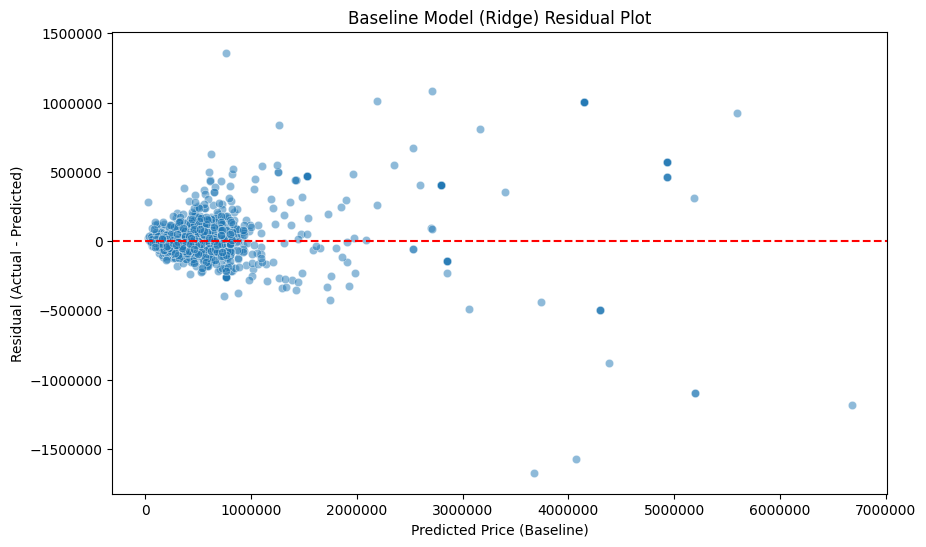

In [33]:
# Create residual plot for Ridge baseline model
# Convert predictions from log space to original price scale
y_test_orig = np.expm1(y_test)
pred_test_orig = np.expm1(pred_test)

baseline_residuals = y_test_orig - pred_test_orig

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pred_test_orig, y=baseline_residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Price (Baseline)')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Baseline Model (Ridge) Residual Plot')
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


## Advanced Model: LightGBM with Target Encoding

Train LightGBM with target encoding for high-cardinality categorical features (make and model). This approach:
- Uses standard preprocessing for numerical and low-cardinality categorical features
- Applies target encoding to high-cardinality features separately
- Combines all features for LightGBM training


In [34]:
# Transform training and test data using preprocessor (numeric + low-card categorical)
X_train_basic = preprocessor_lgb.fit_transform(X_train)
X_test_basic = preprocessor_lgb.transform(X_test)

# Apply target encoding to high-cardinality features (make, model)
te = ce.TargetEncoder(cols=high_card)
te.fit(X_train[high_card], y_train)
X_train_te = te.transform(X_train[high_card])
X_test_te = te.transform(X_test[high_card])

# Combine preprocessed features with target-encoded features
X_train_full = np.hstack([X_train_basic, X_train_te.values]).astype(float)
X_test_full = np.hstack([X_test_basic, X_test_te.values]).astype(float)

# Configure LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbosity': -1,
    'seed': 42
}

# Set up callbacks for early stopping and logging
callbacks = [lgb.early_stopping(100), lgb.log_evaluation(100)]

# Create LightGBM datasets
lgb_train = lgb.Dataset(X_train_full, label=y_train.values)
lgb_valid = lgb.Dataset(X_test_full, label=y_test.values, reference=lgb_train)

# Train LightGBM model with early stopping
model = lgb.train(params, lgb_train, 2000, valid_sets=[lgb_train, lgb_valid], callbacks=callbacks)

# Generate predictions using best iteration
pred_lgb_train = model.predict(X_train_full, num_iteration=model.best_iteration)
pred_lgb_test = model.predict(X_test_full, num_iteration=model.best_iteration)

# Evaluate performance
print('LGB Train:', eval_preds(y_train, pred_lgb_train))
print('LGB Test:', eval_preds(y_test, pred_lgb_test))


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.170223	valid_1's rmse: 0.193451
[200]	training's rmse: 0.153132	valid_1's rmse: 0.189456
[300]	training's rmse: 0.142868	valid_1's rmse: 0.188243
[400]	training's rmse: 0.134904	valid_1's rmse: 0.188068
Early stopping, best iteration is:
[387]	training's rmse: 0.135876	valid_1's rmse: 0.187985
LGB Train: {'RMSE': 82727.51960898083, 'MAE': 45566.257780301465, 'R2_log': 0.9738251626922089}
LGB Test: {'RMSE': 104400.95829336465, 'MAE': 58607.03302615694, 'R2_log': 0.9493086180820641}


In [35]:
# Create stacked ensemble using Ridge and LightGBM predictions
# Stack predictions from Ridge baseline and LightGBM model
stack_train = np.vstack([pred_train, pred_lgb_train]).T
stack_test = np.vstack([pred_test, pred_lgb_test]).T

# Use Lasso as meta-learner for the stacked ensemble
meta = Lasso(alpha=0.1)
meta.fit(stack_train, y_train)
stack_pred_test = meta.predict(stack_test)

# Evaluate stacked model
print('Stacked model test metrics:', eval_preds(y_test, stack_pred_test))


Stacked model test metrics: {'RMSE': 253865.21534396382, 'MAE': 108710.77599040902, 'R2_log': 0.9293583362982352}


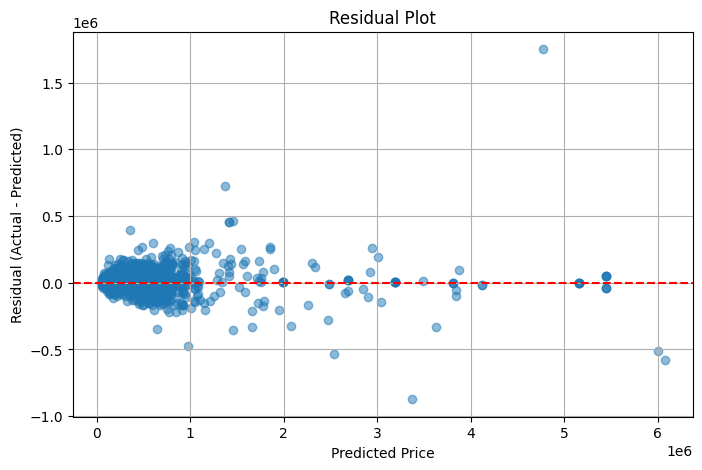

In [36]:
# Create residual plot for LightGBM model
residuals = np.expm1(y_test) - np.expm1(pred_lgb_test)
plt.figure(figsize=(8, 5))
plt.scatter(np.expm1(pred_lgb_test), residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()


In [37]:
# Train quantile regression models for prediction intervals
# Quantiles: 5th percentile (lower bound), 50th percentile (median), 95th percentile (upper bound)
quantiles = [0.05, 0.5, 0.95]
quantile_models = {}

for q in quantiles:
    # Copy base parameters and set quantile objective
    params_q = params.copy()
    params_q['objective'] = 'quantile'
    params_q['alpha'] = q

    # Create dataset and train quantile model
    lgb_tr = lgb.Dataset(X_train_full, label=y_train.values)
    mdl_q = lgb.train(params_q, lgb_tr, 2000, valid_sets=[lgb_tr], callbacks=callbacks)
    quantile_models[q] = mdl_q

# Generate quantile predictions on test set
pred_q = {q: mdl.predict(X_test_full, num_iteration=mdl.best_iteration) for q, mdl in quantile_models.items()}

# Convert predictions from log space to original price scale
lower = np.expm1(pred_q[0.05])      # 5th percentile (lower bound)
median = np.expm1(pred_q[0.5])      # 50th percentile (median prediction)
upper = np.expm1(pred_q[0.95])      # 95th percentile (upper bound)
y_test_orig = np.expm1(y_test)

# Calculate empirical coverage of 90% prediction interval
coverage = ((y_test_orig >= lower) & (y_test_orig <= upper)).mean()
print('Empirical 90% interval coverage:', coverage)

# Evaluate median model performance
print('Median model test metrics:', {
    'RMSE': sqrt(mean_squared_error(y_test_orig, median)),
    'MAE': mean_absolute_error(y_test_orig, median)
})


[100]	training's rmse: 0.599016
[200]	training's rmse: 0.379944
[300]	training's rmse: 0.337036
[400]	training's rmse: 0.327576
[500]	training's rmse: 0.323697
[600]	training's rmse: 0.316653
[700]	training's rmse: 0.312722
[800]	training's rmse: 0.311164
[900]	training's rmse: 0.308907
[1000]	training's rmse: 0.307041
[1100]	training's rmse: 0.305329
[1200]	training's rmse: 0.303421
[1300]	training's rmse: 0.301967
[1400]	training's rmse: 0.300768
[1500]	training's rmse: 0.2994
[1600]	training's rmse: 0.298117
[1700]	training's rmse: 0.297156
[1800]	training's rmse: 0.296222
[1900]	training's rmse: 0.295523
[2000]	training's rmse: 0.294514
[100]	training's rmse: 0.190604
[200]	training's rmse: 0.181032
[300]	training's rmse: 0.176732
[400]	training's rmse: 0.175436
[500]	training's rmse: 0.174434
[600]	training's rmse: 0.173362
[700]	training's rmse: 0.172702
[800]	training's rmse: 0.17196
[900]	training's rmse: 0.171482
[1000]	training's rmse: 0.170978
[1100]	training's rmse: 0.17037

## Cross-Validated Out-of-Fold Training

Implement honest target encoding using cross-validation. This approach:
- Trains separate models on each fold
- Uses out-of-fold predictions to prevent data leakage
- Applies target encoding only on training folds (not validation folds)
- Returns out-of-fold predictions and trained models for each fold


In [38]:
# Out-of-fold cross-validation function with honest target encoding
def get_oof_predictions(X, y, categorical_high=high_card, n_splits=5, random_state=42):
    """
    Generate out-of-fold predictions using honest target encoding.
    Each fold trains a separate model with target encoding applied only to training data.

    Returns:
        oof_pred: Out-of-fold predictions as numpy array
        fold_models: List of dictionaries containing model, target encoder, and preprocessor for each fold
    """
    # Initialize Series to store OOF predictions, preserving index alignment
    oof_pred = pd.Series(index=X.index, dtype=float)
    fold_models = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
        # Split data while preserving original indices
        X_tr, X_val = X.iloc[tr_idx].copy(), X.iloc[val_idx].copy()
        y_tr, y_val = y.iloc[tr_idx].copy(), y.iloc[val_idx].copy()

        # Fit preprocessor on fold training data and transform both train and validation
        preproc_fold = ColumnTransformer(transformers=[
            ('num', numeric_transformer, [c for c in numeric_features if c in X.columns]),
            ('lowcat', cat_low_transformer, categorical_low_card)
        ], remainder='drop')
        X_tr_basic = preproc_fold.fit_transform(X_tr)
        X_val_basic = preproc_fold.transform(X_val)

        # Convert sparse matrices to dense arrays if needed
        if hasattr(X_tr_basic, "toarray"):
            X_tr_basic = X_tr_basic.toarray()
            X_val_basic = X_val_basic.toarray()

        # Fit target encoder on fold training data only (honest encoding)
        te_fold = ce.TargetEncoder(cols=categorical_high)
        te_fold.fit(X_tr[categorical_high], y_tr)
        X_tr_te = te_fold.transform(X_tr[categorical_high])
        X_val_te = te_fold.transform(X_val[categorical_high])

        # Convert target-encoded features to arrays
        X_tr_te_arr = X_tr_te.values if hasattr(X_tr_te, "values") else np.asarray(X_tr_te)
        X_val_te_arr = X_val_te.values if hasattr(X_val_te, "values") else np.asarray(X_val_te)

        # Combine preprocessed and target-encoded features
        X_tr_full = np.hstack([X_tr_basic, X_tr_te_arr])
        X_val_full = np.hstack([X_val_basic, X_val_te_arr])

        # Ensure float dtype
        X_tr_full = X_tr_full.astype(float)
        X_val_full = X_val_full.astype(float)

        # Create LightGBM datasets
        lgb_tr = lgb.Dataset(X_tr_full, label=y_tr.values)
        lgb_val = lgb.Dataset(X_val_full, label=y_val.values, reference=lgb_tr)

        # Train model with early stopping
        callbacks = [lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=0)]
        mdl = lgb.train(
            params,
            lgb_tr,
            num_boost_round=2000,
            valid_sets=[lgb_tr, lgb_val],
            callbacks=callbacks
        )

        # Generate predictions on validation fold and store in OOF predictions
        val_preds = mdl.predict(X_val_full, num_iteration=mdl.best_iteration)
        oof_pred.iloc[val_idx] = val_preds

        # Store model components for this fold
        fold_models.append({'model': mdl, 'te': te_fold, 'preprocessor': preproc_fold})
        print(f'Fold {fold} done; best_iter={mdl.best_iteration}')

    return oof_pred.values, fold_models

# Generate out-of-fold predictions
oof_preds, cv_models = get_oof_predictions(X_train, y_train, n_splits=5)
print('OOF CV metrics:', eval_preds(y_train, oof_preds))


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	training's rmse: 0.152765	valid_1's rmse: 0.196216
Fold 0 done; best_iter=161
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[274]	training's rmse: 0.140196	valid_1's rmse: 0.194691
Fold 1 done; best_iter=274
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[259]	training's rmse: 0.142382	valid_1's rmse: 0.18835
Fold 2 done; best_iter=259
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[229]	training's rmse: 0.146441	valid_1's rmse: 0.188416
Fold 3 done; best_iter=229
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[201]	training's rmse: 0.148231	valid_1's rmse: 0.197334
Fold 4 done; best_iter=201
OOF CV metrics: {'RMSE': 134926.30141119784, 'MAE': 65071.98683557199, 'R2_log': 0.9471684997247

## Quantile Regression Models for Prediction Intervals

Train separate quantile regression models to provide prediction intervals. This allows us to estimate uncertainty in predictions, not just point estimates.


In [39]:
# Train quantile regression models for 5th, 50th (median), and 95th percentiles
quantiles = [0.05, 0.5, 0.95]
quantile_models = {}

for q in quantiles:
    # Configure parameters for quantile regression
    params_q = params.copy()
    params_q['objective'] = 'quantile'
    params_q['alpha'] = q
    print('Training quantile', q)

    # Create dataset and train model
    lgb_tr = lgb.Dataset(X_train_full, label=y_train.values)

    callbacks = [
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ]

    mdl_q = lgb.train(
        params_q,
        lgb_tr,
        num_boost_round=2000,
        valid_sets=[lgb_tr],
        callbacks=callbacks
    )
    quantile_models[q] = mdl_q

# Generate quantile predictions on test set
pred_q = {q: mdl.predict(X_test_full, num_iteration=mdl.best_iteration) for q, mdl in quantile_models.items()}


Training quantile 0.05
[100]	training's rmse: 0.599016
[200]	training's rmse: 0.379944
[300]	training's rmse: 0.337036
[400]	training's rmse: 0.327576
[500]	training's rmse: 0.323697
[600]	training's rmse: 0.316653
[700]	training's rmse: 0.312722
[800]	training's rmse: 0.311164
[900]	training's rmse: 0.308907
[1000]	training's rmse: 0.307041
[1100]	training's rmse: 0.305329
[1200]	training's rmse: 0.303421
[1300]	training's rmse: 0.301967
[1400]	training's rmse: 0.300768
[1500]	training's rmse: 0.2994
[1600]	training's rmse: 0.298117
[1700]	training's rmse: 0.297156
[1800]	training's rmse: 0.296222
[1900]	training's rmse: 0.295523
[2000]	training's rmse: 0.294514
Training quantile 0.5
[100]	training's rmse: 0.190604
[200]	training's rmse: 0.181032
[300]	training's rmse: 0.176732
[400]	training's rmse: 0.175436
[500]	training's rmse: 0.174434
[600]	training's rmse: 0.173362
[700]	training's rmse: 0.172702
[800]	training's rmse: 0.17196
[900]	training's rmse: 0.171482
[1000]	training's r

## SHAP Interpretability Analysis

Use SHAP (SHapley Additive exPlanations) to understand feature importance and model interpretability. This provides global feature importance rankings.


Feature count 24


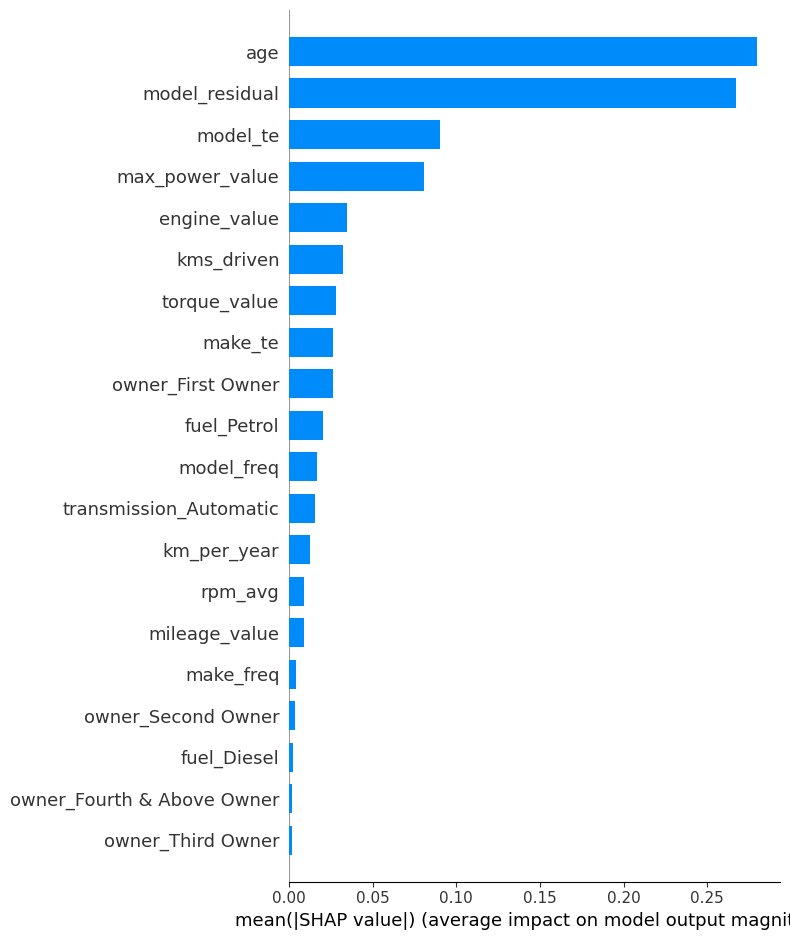

In [40]:
# Create SHAP explainer for the trained LightGBM model
explainer = shap.TreeExplainer(model)

# Use subset of test data for SHAP computation (limit to 2000 rows for efficiency)
X_shap = X_test_full if X_test_full.shape[0] <= 2000 else X_test_full[:2000]
shap_values = explainer.shap_values(X_shap)

# Build feature names matching the combined feature matrix structure
# Extract numeric feature names
num_names = [c for c in numeric_features if c in df.columns]

# Extract one-hot encoded categorical feature names
lowcat_ohe = preprocessor_lgb.named_transformers_['lowcat'].named_steps['onehot']
lowcat_cols = lowcat_ohe.get_feature_names_out(categorical_low_card).tolist() if categorical_low_card else []

# Create names for target-encoded features
high_cols = [f"{c}_te" for c in high_card]

# Combine all feature names
feature_names = num_names + lowcat_cols + high_cols

print('Feature count', len(feature_names))

# Generate SHAP summary plot
try:
    shap.summary_plot(shap_values, pd.DataFrame(X_shap, columns=feature_names), plot_type='bar')
except Exception as e:
    print('SHAP plotting error (may be running headless). You can export or save plots locally.', e)


In [41]:
# Feature Engineering Transformer Class
# This class can be used to transform raw car data for inference
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    """
    Transforms raw car data by extracting make/model, calculating age/km_per_year,
    and adding frequency/residual features.

    This transformer learns frequency maps and model averages from training data
    and applies them to new data during inference.
    """
    def __init__(self):
        self.make_freq_map_ = None
        self.model_freq_map_ = None
        self.model_avg_map_ = None
        self.log_price_mean_ = None
        self.current_year_ = None

    def fit(self, X, y=None):
        """
        Fit the transformer on training data to learn frequency maps and averages.

        Args:
            X: Training data with columns including 'name', 'year', 'kms_driven'
            y: Target values (log_selling_price) for calculating model averages
        """
        X = X.copy()
        self.current_year_ = datetime.now().year

        # Extract make and model from name column
        X['make'] = X['name'].fillna('').str.split().str[0].fillna('Unknown')
        X['model'] = X['name'].fillna('').str.split().str[1].fillna('Unknown')

        # Calculate age and km_per_year
        X['age'] = self.current_year_ - X['year'].fillna(self.current_year_)
        X['age'] = X['age'].replace(0, 1)  # Avoid division by zero
        X['km_per_year'] = X['kms_driven'].fillna(0) / X['age']

        # Learn frequency maps from training data
        self.make_freq_map_ = X['make'].value_counts(normalize=True).to_dict()
        self.model_freq_map_ = X['model'].value_counts(normalize=True).to_dict()

        # Learn model averages and overall mean (if target is provided)
        if y is not None:
            X_temp = X.copy()
            X_temp['log_selling_price'] = y
            self.log_price_mean_ = y.mean()
            self.model_avg_map_ = X_temp.groupby('model')['log_selling_price'].mean().to_dict()
        else:
            self.log_price_mean_ = 0
            self.model_avg_map_ = {}

        return self

    def transform(self, X):
        """
        Transform input data by deriving features.

        Args:
            X: Input data with columns including 'name', 'year', 'kms_driven'

        Returns:
            Transformed dataframe with additional features
        """
        X = X.copy()
        current_year = self.current_year_ if self.current_year_ else datetime.now().year

        # Extract make and model
        X['make'] = X['name'].fillna('').str.split().str[0].fillna('Unknown')
        X['model'] = X['name'].fillna('').str.split().str[1].fillna('Unknown')

        # Calculate age and km_per_year
        X['age'] = current_year - X['year'].fillna(current_year)
        X['age'] = X['age'].replace(0, 1)  # Avoid division by zero
        X['km_per_year'] = X['kms_driven'].fillna(0) / X['age']

        # Add frequency features using learned maps
        if self.make_freq_map_:
            X['make_freq'] = X['make'].map(self.make_freq_map_).fillna(0)
        else:
            X['make_freq'] = 0

        if self.model_freq_map_:
            X['model_freq'] = X['model'].map(self.model_freq_map_).fillna(0)
        else:
            X['model_freq'] = 0

        # Add model residual feature (deviation from overall mean)
        if self.model_avg_map_ and self.log_price_mean_:
            X['model_residual'] = X['model'].map(self.model_avg_map_).fillna(self.log_price_mean_) - self.log_price_mean_
        else:
            X['model_residual'] = 0

        return X


## Model Artifact Serialization

Save all trained models and preprocessing components for deployment and inference.


In [42]:
# Create artifacts directory if it doesn't exist
os.makedirs('artifacts', exist_ok=True)

# Save preprocessing pipeline
joblib.dump(preprocessor_lgb, 'artifacts/preprocessor_lgb.joblib')

# Save target encoder
joblib.dump(te, 'artifacts/target_encoder.joblib')

# Save main LightGBM model
model.save_model('artifacts/lgb_model.txt')

# Save quantile regression models
for q, mdl in quantile_models.items():
    mdl.save_model(f'artifacts/lgb_quantile_{int(q*100)}.txt')

# Note: FeatureEngineeringTransformer can be created and saved if needed for inference
# parser = FeatureEngineeringTransformer()
# parser.fit(X_train, y_train)
# joblib.dump(parser, 'artifacts/parser.joblib')

print('Artifacts saved to artifacts/ directory')


Artifacts saved to artifacts/ directory


In [43]:
# Single-row inference function for making predictions on new car data
def predict_single(row_dict,
                   preprocessor_path='artifacts/preprocessor_lgb.joblib',
                   te_path='artifacts/target_encoder.joblib',
                   model_path='artifacts/lgb_model.txt'):
    """
    Predict selling price for a single car using saved model artifacts.

    Args:
        row_dict: Dictionary containing car features (name, year, kms_driven, etc.)
        preprocessor_path: Path to saved preprocessor
        te_path: Path to saved target encoder
        model_path: Path to saved LightGBM model

    Returns:
        Predicted selling price (in original scale, not log-transformed)
    """
    # Load saved artifacts
    pre = joblib.load(preprocessor_path)
    te_local = joblib.load(te_path)
    mdl = lgb.Booster(model_file=model_path)
    # Note: parser can be loaded if FeatureEngineeringTransformer was saved
    # parser = joblib.load('artifacts/parser.joblib')

    # Build DataFrame with expected columns, filling missing with NaN
    required_raw = ['name', 'year', 'kms_driven']  # Required for feature derivation
    expected_cols = list(set(numeric_features + categorical_low_card + high_card + required_raw))

    # Create row DataFrame
    row = {col: row_dict.get(col, np.nan) for col in expected_cols}
    Xrow = pd.DataFrame([row])

    # Note: If parser is available, apply it here to derive make/model/age/km_per_year
    # Xrow = parser.transform(Xrow)

    # Transform using preprocessor (handles numeric and low-card categorical features)
    X_basic = pre.transform(Xrow)

    # Convert sparse matrix to dense array if needed
    if hasattr(X_basic, "toarray"):
        X_basic = X_basic.toarray()

    # Ensure high-cardinality columns exist for target encoding
    for c in high_card:
        if c not in Xrow.columns:
            Xrow[c] = np.nan

    # Apply target encoding to high-cardinality features
    X_te = te_local.transform(Xrow[high_card])
    X_te_arr = X_te.values if hasattr(X_te, "values") else np.asarray(X_te)

    # Combine all features
    X_full = np.hstack([X_basic, X_te_arr]).astype(float)

    # Generate prediction using best iteration if available
    best_it = getattr(mdl, "best_iteration", None)
    if best_it is not None and best_it > 0:
        pred_log = mdl.predict(X_full, num_iteration=best_it)[0]
    else:
        pred_log = mdl.predict(X_full)[0]

    # Convert from log space to original price scale
    return float(np.expm1(pred_log))


# Example: Test inference function on first 10 test samples
results = []
for i in range(10):
    example_row = X_test.iloc[i].to_dict()
    actual_price = float(np.expm1(y_test.iloc[i]))
    predicted_price = predict_single(example_row)

    results.append([
        i + 1,                # Serial number
        actual_price,
        predicted_price
    ])

# Create results DataFrame
results_df = pd.DataFrame(
    results,
    columns=["Sl No", "Ground truth selling price", "Predicted selling price"]
)
results_df = results_df.set_index("Sl No")

# Display formatted results
results_df.style.format({
    "Ground truth selling price": "{:,.0f}",
    "Predicted selling price": "{:,.0f}"
})


,Ground truth selling price,Predicted selling price
Sl No,,
1,"689,691","616,113"
2,"210,028","207,337"
3,"839,028","755,747"
4,"465,095","507,282"
5,"350,108","333,754"
6,"360,050","354,981"
7,"50,010","50,843"
8,"149,940","195,889"
9,"360,050","366,912"


## Future Improvements and Recommendations

- **Enhanced Name Parsing**: Use regex patterns or fuzzy matching against a curated make/model database for more accurate extraction
- **Leakage Testing**: Evaluate models with and without potentially leaked features to ensure robustness
- **Small Dataset Considerations**: For smaller datasets, prefer simpler models with strong cross-validation; consider ensembling multiple CV folds
- **Calibrated Prediction Intervals**: Implement conformalized quantile regression for better-calibrated uncertainty estimates
- **Testing**: Add unit tests for preprocessing pipeline and inference function before production deployment
- **Feature Engineering**: Explore additional derived features such as brand reputation scores, depreciation curves, or market segment indicators
